실제로 Learning rate 를 scheduler 에 따라서 적용시키는 실습을 해보자

In [91]:
import torch.optim.lr_scheduler as lr_scheduler
import pytorch_lightning as pl
import torch
from torch import nn
from torchmetrics import functional as FM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [92]:
lr = 0.005
loss_fucntion = nn.CrossEntropyLoss()

In [93]:
class myModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            #nn.ReLU(),
            nn.Linear(64, 10),
            #nn.ReLU(),
            #nn.Linear(32, 16),
            #nn.ReLU(),
            #nn.Linear(16, 10),
            #nn.Softmax()
        )

    def forward(self, x):
        out = self.layers(x)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_fucntion(y_pred, y)
        acc = FM.accuracy(y_pred, y, task='multiclass',  num_classes=10)
        metrics = {'loss' : loss,  'acc' : acc}
        #self.log_dict( metrics, prog_bar=True )
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_fucntion(y_pred, y)
        acc = FM.accuracy(y_pred, y, task='multiclass',  num_classes=10)
        metrics = {'val_loss' : loss,  'val_acc' : acc}
        self.log_dict(metrics, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        return optimizer 


    

In [94]:
model = myModel()

In [95]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
myModel                                  --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       50,240
│    └─Linear: 2-3                       650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0

In [96]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils import data
from torch.utils.data import DataLoader

class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, data_dir: str = '', batch_size: int = 32):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size

  def setup(self, stage):
    # transforms for images
    transform=transforms.Compose([transforms.ToTensor(), # 1/255,tensor로 변환
                                  transforms.Normalize((0.1307,), (0.3081,))])
    self.mnist_test = MNIST(self.data_dir, train=False, transform=transform, download=True)
    mnist_full = MNIST(self.data_dir, train=True, transform=transform, download=True)
    self.mnist_train, self.mnist_val = data.random_split(mnist_full, [55000, 5000])

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=self.batch_size)
  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=self.batch_size)
  def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size=self.batch_size)

data_module = MNISTDataModule(batch_size=256)

In [97]:
torch.set_float32_matmul_precision('medium')

In [98]:
%%time

epoch=30
logger = pl.loggers.CSVLogger("logs", name = "myModel_const_lr")

trainer = pl.Trainer(max_epochs=epoch, logger = logger, accelerator='auto')
trainer.fit(model, data_module)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 50.9 K | train
----------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


CPU times: total: 31.8 s
Wall time: 4min 10s


In [99]:
version_number = logger.version
log_file = f'./logs/myModel_const_lr/version_{version_number}/metrics.csv'
logs = pd.read_csv(log_file)


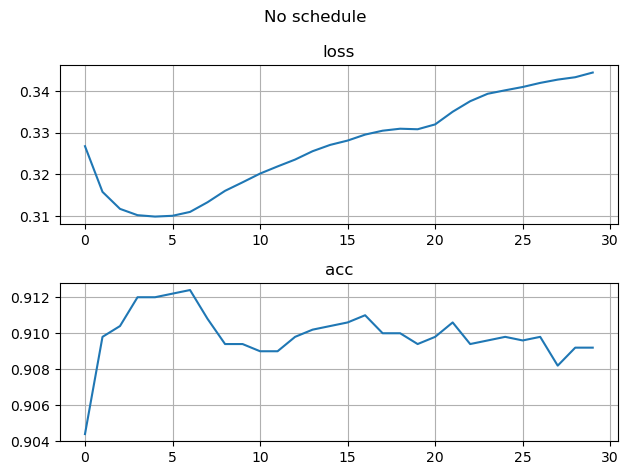

In [103]:
val_logs = logs[['val_loss', 'val_acc']].dropna().reset_index()
plt.suptitle("No schedule")
plt.subplot(2, 1, 1)
plt.plot(val_logs['val_loss'])
plt.title("loss")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(val_logs['val_acc'])
plt.title("acc")
plt.grid()

plt.tight_layout()

In [ ]:
## now apply lr scheduler 



In [104]:
decay_steps = 7
gamma = 0.1
exponential_decay_step = lambda epoch : gamma ** ( epoch // decay_steps )


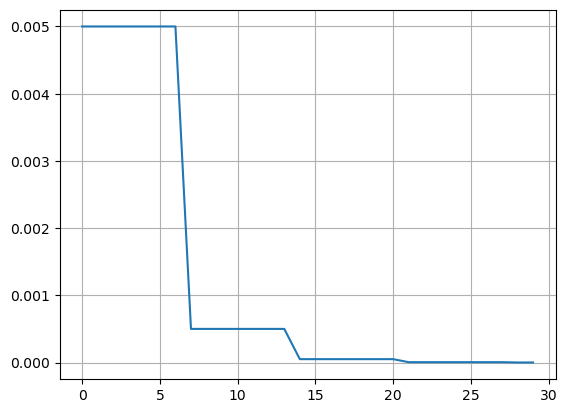

In [107]:
epochs = np.arange(0, 30)
decay_values = [exponential_decay_step(epoch) * lr for epoch in epochs]
plt.plot(epochs, decay_values)
plt.grid()



In [108]:
import torch.optim.lr_scheduler as lr_scheduler

class model_expo_decay( myModel ):

    def __init__(self):
        super().__init__()

    def configure_optimizers(self):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        lr_s = lr_scheduler.LambdaLR(optimizer, lr_lambda= exponential_decay_step, verbose=True)

        return [optimizer], [lr_s]
    
    

In [109]:
mymodel2 = model_expo_decay()
logger = pl.loggers.CSVLogger("logs", name='decaying_lr')
trainer = pl.Trainer( max_epochs=30, logger=logger, accelerator='auto')
trainer.fit(mymodel2, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: logs\decaying_lr
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\msong\anaconda3\envs\py3_11_8\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 50.9 K | train
----------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\msong\anaconda3\envs\py3_11_8\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\msong\anaconda3\envs\py3_11_8\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


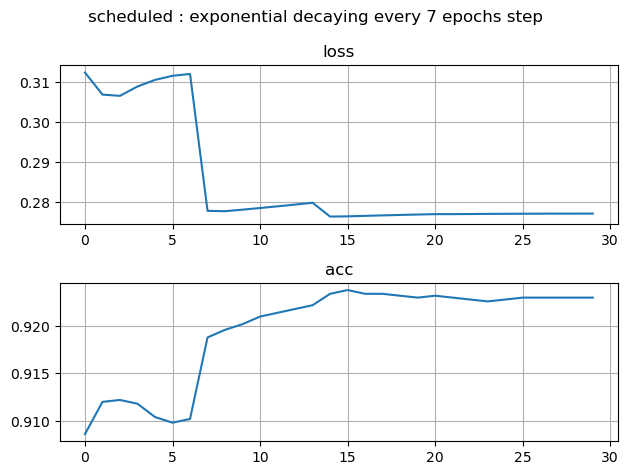

In [111]:
version_number = logger.version
log_file = f'./logs/decaying_lr/version_{version_number}/metrics.csv'
logs = pd.read_csv(log_file)


val_logs = logs[['val_loss', 'val_acc']].dropna().reset_index()
plt.suptitle("scheduled : exponential decaying every 7 epochs step")
plt.subplot(2, 1, 1)
plt.plot(val_logs['val_loss'])
plt.title("loss")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(val_logs['val_acc'])
plt.title("acc")
plt.grid()

plt.tight_layout()